In [1]:
import re
import numpy as np
import pandas as pd

from utils import preprocess, plotutils

from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn import metrics
from sklearn.pipeline import Pipeline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F

import random
from tqdm import tqdm
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
from spacy.lang.en import stop_words
from string import punctuation
import emoji
from utils import preprocess, preprocess_LIU, plotutils
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed_all(seed)

In [2]:
%load_ext autoreload
%autoreload 2

## Glove Embedding

In [3]:
DATA_DIR = "./data/"
TRAIN_DATA_FILE = DATA_DIR + "olid-training-v1.0.tsv"
TEST_A_DATA_FILE = DATA_DIR + "testset-levela.tsv"
LABEL_A_DATA_FILE = DATA_DIR + "labels-levela.csv"
TEST_B_DATA_FILE = DATA_DIR + "testset-levelb.tsv"
LABEL_B_DATA_FILE = DATA_DIR + "labels-levelb.csv"
TEST_C_DATA_FILE = DATA_DIR + "testset-levelc.tsv"
LABEL_C_DATA_FILE = DATA_DIR + "labels-levelc.csv"

ori_train_data = pd.read_csv(TRAIN_DATA_FILE, sep='\t')

task_a_test_data = pd.read_csv(TEST_A_DATA_FILE, sep='\t')
task_a_test_label = pd.read_csv(LABEL_A_DATA_FILE, usecols=[1], names=['labela'])

task_b_test_data = pd.read_csv(TEST_B_DATA_FILE, sep='\t')
task_b_test_label = pd.read_csv(LABEL_B_DATA_FILE, usecols=[1], names=['labelb'])

task_c_test_data = pd.read_csv(TEST_C_DATA_FILE, sep='\t')
task_c_test_label = pd.read_csv(LABEL_C_DATA_FILE, usecols=[1], names=['labelc'])

### Task A - training

In [4]:
tweet_list = ori_train_data['tweet'].to_list()
processed_tweet_list = [preprocess.glove_twitter_preprocess(t) for t in tweet_list]
tokenized_tweet_list = preprocess.nltk_tokenize(processed_tweet_list)
vocabulary, documents_vector = preprocess.transform_word_to_vector(tokenized_tweet_list, num_vocab=20000, padded=False)

pretrained_embedding = preprocess.get_embedding_from_torch_text(vocabulary, "twitter.27B", 200)
pretrained_embedding.shape

torch.Size([19034, 200])

In [5]:
label2id = {'NOT': 0, 'OFF': 1}
sub_a_label = ori_train_data['subtask_a'].map(label2id).to_list()
sentences_train, sentences_test, labels_train, labels_test = train_test_split(documents_vector, sub_a_label, test_size=0.2, random_state=5246)
y_train = np.asarray(labels_train)
y_test = np.asarray(labels_test)

count_not, count_off= np.sum(y_train == 0), np.sum(y_train == 1)
weight_not = len(y_train) / (2 * count_not)
weight_off = len(y_train) / (2 * count_off)
class_weights = torch.FloatTensor([weight_not, weight_off])

In [6]:
def collate_fn(batch):
    batch.sort(key=lambda x: x[2], reverse=True)
    sequences, labels, lengths = zip(*batch)
    sequences = nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=0.0)
    return sequences, torch.tensor(labels), torch.tensor(lengths)

class TextDataset(Dataset):
    def __init__(self, sentences, labels):
        self.sentences = sentences
        self.labels = labels

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        return self.sentences[idx], torch.tensor(self.labels[idx]), len(self.sentences[idx])


class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, pretrained_embedding):
        super(LSTMClassifier, self).__init__()

        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding.from_pretrained(pretrained_embedding)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2 * hidden_dim, output_dim)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, lengths):
        batch_size = x.size(0)
        x = self.embedding(x)
        h0 = torch.zeros(2, batch_size, self.hidden_dim).requires_grad_()
        c0 = torch.zeros(2, batch_size, self.hidden_dim).requires_grad_()

        x = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        out = self.fc(torch.cat((hn[-2], hn[-1]), dim=1))
        return self.log_softmax(out)

Epoch [1/10], Loss: 0.5483, Train F1: 0.6362, Val F1: 0.7398
Epoch [2/10], Loss: 0.4571, Train F1: 0.7447, Val F1: 0.7380
Epoch [3/10], Loss: 0.4228, Train F1: 0.7754, Val F1: 0.7251
Epoch [4/10], Loss: 0.3942, Train F1: 0.7954, Val F1: 0.7423
Epoch [5/10], Loss: 0.3588, Train F1: 0.8188, Val F1: 0.7339
Epoch [6/10], Loss: 0.3070, Train F1: 0.8517, Val F1: 0.7293
Epoch [7/10], Loss: 0.2508, Train F1: 0.8824, Val F1: 0.7074
Epoch [8/10], Loss: 0.1861, Train F1: 0.9194, Val F1: 0.7215
Epoch [9/10], Loss: 0.1226, Train F1: 0.9532, Val F1: 0.7151
Epoch [10/10], Loss: 0.0782, Train F1: 0.9711, Val F1: 0.7211
Classification report for best model on validation set:
              precision    recall  f1-score   support

         NOT       0.81      0.88      0.84      1750
         OFF       0.72      0.58      0.64       898

    accuracy                           0.78      2648
   macro avg       0.76      0.73      0.74      2648
weighted avg       0.77      0.78      0.77      2648



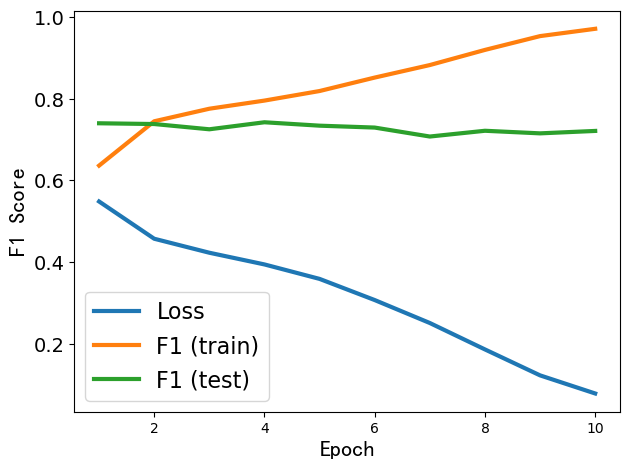

In [7]:
embedding_dim = pretrained_embedding.size(1)
hidden_dim = 64
output_dim = 2
lr = 0.001
num_epochs = 10

model = LSTMClassifier(embedding_dim, hidden_dim, output_dim, pretrained_embedding)
criterion = nn.NLLLoss()
# criterion = nn.NLLLoss(weight=class_weights)
# criterion = nn.CrossEntropyLoss(weight=class_weights)
# optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-3)

train_dataset = TextDataset(sentences_train, y_train)
test_dataset = TextDataset(sentences_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

train_losses = []
train_f1_scores = []
val_f1_scores = []
best_val_f1 = 0
best_model_path = 'best_model_a.pt'

for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_preds = []
    epoch_labels = []

    # Training loop
    model.train()
    for i, (inputs, labels, lengths) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs.long(), lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        epoch_preds.extend(predicted.cpu().numpy())
        epoch_labels.extend(labels.cpu().numpy())

    train_losses.append(epoch_loss / len(train_loader))
    train_f1_scores.append(f1_score(epoch_labels, epoch_preds, average='macro'))

    # Validation loop
    model.eval()
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for inputs, labels, lengths in test_loader:
            outputs = model(inputs.long(), lengths)
            _, predicted = torch.max(outputs.data, 1)
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_f1 = f1_score(val_labels, val_preds, average='macro')
    val_f1_scores.append(val_f1)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {train_losses[-1]:.4f}, Train F1: {train_f1_scores[-1]:.4f}, Val F1: {val_f1_scores[-1]:.4f}")

    # Save the best model based on validation F1 score
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), best_model_path)

# Load the best model
model.load_state_dict(torch.load(best_model_path))
model.eval()
val_preds = []
val_labels = []
with torch.no_grad():
    for inputs, labels, lengths in test_loader:
        outputs = model(inputs.long(), lengths)
        _, predicted = torch.max(outputs.data, 1)
        val_preds.extend(predicted.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

print("Classification report for best model on validation set:")
print(metrics.classification_report(val_labels, val_preds, target_names=['NOT', 'OFF']))

# Plotting
font_axes = {'family':'serif','color':'black','size':16}
epochs = range(1, num_epochs + 1)
plt.figure()
plt.plot(epochs, train_losses, lw=3)
plt.plot(epochs, train_f1_scores, lw=3)
plt.plot(epochs, val_f1_scores, lw=3)
plt.yticks(fontsize=14)
plt.xlabel("Epoch", fontdict=font_axes)
plt.ylabel("F1 Score", fontdict=font_axes)
plt.legend(['Loss', 'F1 (train)', 'F1 (test)'], loc='lower left', fontsize=16)
plt.tight_layout()
plt.show()  

#### Test task a

In [8]:
tweets_test_a = task_a_test_data["tweet"].tolist()
processed_tweet_list_a = [preprocess.glove_twitter_preprocess(t) for t in tweets_test_a]
tokenized_tweet_list_a = preprocess.nltk_tokenize(processed_tweet_list_a)
# _ , documents_vector_a = preprocess.transform_word_to_vector(tokenized_tweet_list_a, num_vocab=20000, padded=False)
documents_vector_a = preprocess.get_vector_from_vocabulary(vocabulary, tokenized_tweet_list_a)

sub_a_label_test = task_a_test_label['labela'].map(label2id).to_list()
test_a_dataset = TextDataset(documents_vector_a, sub_a_label_test)
test_a_loader = DataLoader(test_a_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

best_model = LSTMClassifier(embedding_dim, hidden_dim, output_dim, pretrained_embedding)
best_model.load_state_dict(torch.load(best_model_path))
best_model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    pred, label = [],[]
    for i, (inputs, labels, lengths) in enumerate(test_a_loader):
        outputs = best_model(inputs.long(), lengths)
        _, predicted = torch.max(outputs.data, 1)
        pred.append(predicted)
        label.append(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.2f}%")

y_pred = np.asarray(torch.cat(pred))
y_label = np.asarray(torch.cat(label))
print(metrics.f1_score(y_label, y_pred, average='micro'))
print(metrics.classification_report(y_label, y_pred, target_names=['NOT', 'OFF']))

Test Accuracy: 80.35%
0.8034883720930233
              precision    recall  f1-score   support

         NOT       0.81      0.95      0.87       620
         OFF       0.78      0.42      0.54       240

    accuracy                           0.80       860
   macro avg       0.79      0.68      0.71       860
weighted avg       0.80      0.80      0.78       860



### Task B - training

In [35]:
sub_b_idx = list(ori_train_data[ori_train_data['subtask_b'].notna()].index)
tweet_list = ori_train_data.loc[sub_b_idx]['tweet'].to_list()
processed_tweet_list = [preprocess.glove_twitter_preprocess(t) for t in tweet_list]
tokenized_tweet_list = preprocess.nltk_tokenize(processed_tweet_list)
vocabulary, documents_vector = preprocess.transform_word_to_vector(tokenized_tweet_list, num_vocab=20000, padded=False)
pretrained_embedding = preprocess.get_embedding_from_torch_text(vocabulary, "twitter.27B", 200)
pretrained_embedding.shape

torch.Size([10335, 200])

In [36]:
label2id = {'UNT': 0, 'TIN': 1}
sub_b_label = ori_train_data.loc[sub_b_idx]['subtask_b'].map(label2id).to_list()
sentences_train, sentences_test, labels_train, labels_test = train_test_split(documents_vector, sub_b_label, test_size=0.2, random_state=5246)
y_train = np.asarray(labels_train)
y_test = np.asarray(labels_test)

count_unt, count_tin= np.sum(y_train == 0), np.sum(y_train == 1)
weight_unt = len(y_train) / (2 * count_unt)
weight_tin = len(y_train) / (2 * count_tin)
class_weights = torch.FloatTensor([weight_unt, weight_tin])

Epoch [1/10], Loss: 0.6749, Train F1: 0.5085, Val F1: 0.5722
Epoch [2/10], Loss: 0.6253, Train F1: 0.5853, Val F1: 0.6242
Epoch [3/10], Loss: 0.5783, Train F1: 0.6095, Val F1: 0.5670
Epoch [4/10], Loss: 0.5389, Train F1: 0.6370, Val F1: 0.5725
Epoch [5/10], Loss: 0.4559, Train F1: 0.6839, Val F1: 0.5626
Epoch [6/10], Loss: 0.3517, Train F1: 0.7399, Val F1: 0.5002
Epoch [7/10], Loss: 0.2581, Train F1: 0.8043, Val F1: 0.5889
Epoch [8/10], Loss: 0.1915, Train F1: 0.8544, Val F1: 0.6008
Epoch [9/10], Loss: 0.1143, Train F1: 0.9039, Val F1: 0.6000
Epoch [10/10], Loss: 0.0743, Train F1: 0.9402, Val F1: 0.5907
Classification report for best model on validation set:
              precision    recall  f1-score   support

         UNT       0.37      0.32      0.34       117
         TIN       0.90      0.92      0.91       763

    accuracy                           0.84       880
   macro avg       0.63      0.62      0.62       880
weighted avg       0.83      0.84      0.83       880



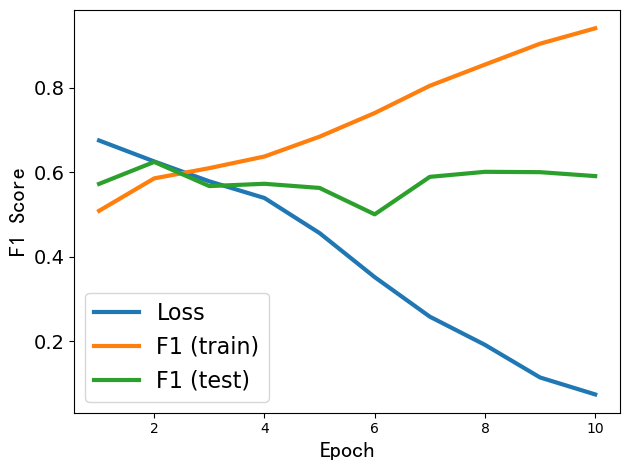

In [37]:
embedding_dim = pretrained_embedding.size(1)
hidden_dim = 64
output_dim = 2
lr = 0.001
num_epochs = 10

model = LSTMClassifier(embedding_dim, hidden_dim, output_dim, pretrained_embedding)
criterion = nn.NLLLoss(weight=class_weights)
# criterion = nn.CrossEntropyLoss(weight=class_weights)
# optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-3)

train_dataset = TextDataset(sentences_train, y_train)
test_dataset = TextDataset(sentences_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

train_losses = []
train_f1_scores = []
val_f1_scores = []
best_val_f1 = 0
best_model_path = 'best_model_b.pt'

for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_preds = []
    epoch_labels = []

    # Training loop
    model.train()
    for i, (inputs, labels, lengths) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs.long(), lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        epoch_preds.extend(predicted.cpu().numpy())
        epoch_labels.extend(labels.cpu().numpy())

    train_losses.append(epoch_loss / len(train_loader))
    train_f1_scores.append(f1_score(epoch_labels, epoch_preds, average='macro'))

    # Validation loop
    model.eval()
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for inputs, labels, lengths in test_loader:
            outputs = model(inputs.long(), lengths)
            _, predicted = torch.max(outputs.data, 1)
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_f1 = f1_score(val_labels, val_preds, average='macro')
    val_f1_scores.append(val_f1)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {train_losses[-1]:.4f}, Train F1: {train_f1_scores[-1]:.4f}, Val F1: {val_f1_scores[-1]:.4f}")

    # Save the best model based on validation F1 score
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), best_model_path)

# Load the best model
model.load_state_dict(torch.load(best_model_path))
model.eval()
val_preds = []
val_labels = []
with torch.no_grad():
    for inputs, labels, lengths in test_loader:
        outputs = model(inputs.long(), lengths)
        _, predicted = torch.max(outputs.data, 1)
        val_preds.extend(predicted.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

print("Classification report for best model on validation set:")
print(metrics.classification_report(val_labels, val_preds, target_names=['UNT', 'TIN']))

# Plotting
font_axes = {'family':'serif','color':'black','size':16}
epochs = range(1, num_epochs + 1)
plt.figure()
plt.plot(epochs, train_losses, lw=3)
plt.plot(epochs, train_f1_scores, lw=3)
plt.plot(epochs, val_f1_scores, lw=3)
plt.yticks(fontsize=14)
plt.xlabel("Epoch", fontdict=font_axes)
plt.ylabel("F1 Score", fontdict=font_axes)
plt.legend(['Loss', 'F1 (train)', 'F1 (test)'], loc='lower left', fontsize=16)
plt.tight_layout()
plt.show()  


#### Test task b

In [38]:
tweets_test_b = task_b_test_data["tweet"].tolist()
processed_tweet_list_b = [preprocess.glove_twitter_preprocess(t) for t in tweets_test_b]
tokenized_tweet_list_b = preprocess.nltk_tokenize(processed_tweet_list_b)
documents_vector_b = preprocess.get_vector_from_vocabulary(vocabulary, tokenized_tweet_list_b)

sub_b_label_test = task_b_test_label['labelb'].map(label2id).to_list()
test_b_dataset = TextDataset(documents_vector_b, sub_b_label_test)
test_b_loader = DataLoader(test_b_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

best_model = LSTMClassifier(embedding_dim, hidden_dim, output_dim, pretrained_embedding)
best_model.load_state_dict(torch.load(best_model_path))
best_model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    pred, label = [],[]
    for i, (inputs, labels, lengths) in enumerate(test_b_loader):
        outputs = model(inputs.long(), lengths)
        _, predicted = torch.max(outputs.data, 1)
        pred.append(predicted)
        label.append(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.2f}%")

y_pred = np.asarray(torch.cat(pred))
y_label = np.asarray(torch.cat(label))
print(metrics.f1_score(y_label, y_pred, average='micro'))
print(metrics.classification_report(y_label, y_pred, target_names=['UNT', 'TIN']))

Test Accuracy: 76.67%
0.7666666666666667
              precision    recall  f1-score   support

         UNT       0.28      0.67      0.39        27
         TIN       0.95      0.78      0.86       213

    accuracy                           0.77       240
   macro avg       0.61      0.72      0.62       240
weighted avg       0.87      0.77      0.80       240



### Task C - training

In [39]:
sub_c_idx = list(ori_train_data[ori_train_data['subtask_c'].notna()].index)
tweet_list = ori_train_data.loc[sub_c_idx]['tweet'].to_list()
processed_tweet_list = [preprocess.glove_twitter_preprocess(t) for t in tweet_list]
tokenized_tweet_list = preprocess.nltk_tokenize(processed_tweet_list)
vocabulary, documents_vector = preprocess.transform_word_to_vector(tokenized_tweet_list, num_vocab=20000, padded=False)
pretrained_embedding = preprocess.get_embedding_from_torch_text(vocabulary, "twitter.27B", 200)
pretrained_embedding.shape

torch.Size([9679, 200])

In [40]:
label2id = {'IND': 0, 'GRP': 1, 'OTH': 2}
sub_c_label = ori_train_data.loc[sub_c_idx]['subtask_c'].map(label2id).to_list()
sentences_train, sentences_test, labels_train, labels_test = train_test_split(documents_vector, sub_c_label, test_size=0.2, random_state=5246)
y_train = np.asarray(labels_train)
y_test = np.asarray(labels_test)

count_ind, count_grp, count_oth = np.sum(y_train == 0), np.sum(y_train == 1), np.sum(y_train == 1)
weight_ind = len(y_train) / (3 * count_ind)
weight_grp = len(y_train) / (3 * count_grp)
weight_oth = len(y_train) / (3 * count_oth)
class_weights = torch.FloatTensor([weight_ind, weight_grp, weight_oth])

Epoch [1/10], Loss: 0.9384, Train F1: 0.4120, Val F1: 0.4691
Epoch [2/10], Loss: 0.8244, Train F1: 0.4708, Val F1: 0.4768
Epoch [3/10], Loss: 0.7727, Train F1: 0.4984, Val F1: 0.4891
Epoch [4/10], Loss: 0.7318, Train F1: 0.5456, Val F1: 0.4852
Epoch [5/10], Loss: 0.6811, Train F1: 0.5789, Val F1: 0.5181
Epoch [6/10], Loss: 0.6095, Train F1: 0.6562, Val F1: 0.4861
Epoch [7/10], Loss: 0.5318, Train F1: 0.7081, Val F1: 0.5381
Epoch [8/10], Loss: 0.4345, Train F1: 0.7818, Val F1: 0.5371
Epoch [9/10], Loss: 0.3118, Train F1: 0.8508, Val F1: 0.5158
Epoch [10/10], Loss: 0.2200, Train F1: 0.9025, Val F1: 0.5220
Classification report for best model on validation set:
              precision    recall  f1-score   support

         IND       0.84      0.72      0.78       500
         GRP       0.57      0.66      0.61       203
         OTH       0.19      0.29      0.23        73

    accuracy                           0.66       776
   macro avg       0.53      0.56      0.54       776
weighte

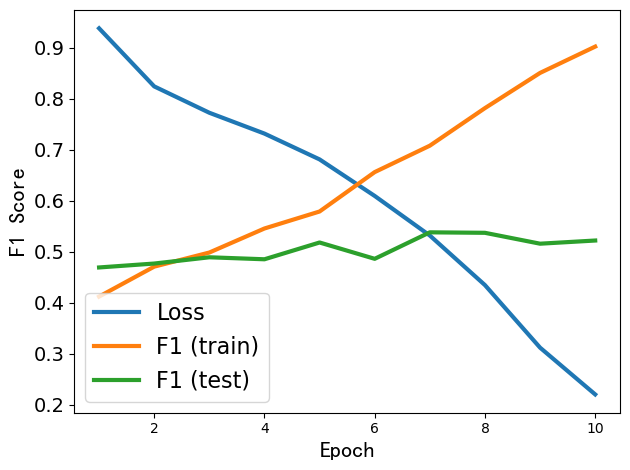

In [41]:
embedding_dim = pretrained_embedding.size(1)
hidden_dim = 64
output_dim = 3
lr = 0.001
num_epochs = 10

model = LSTMClassifier(embedding_dim, hidden_dim, output_dim, pretrained_embedding)
criterion = nn.NLLLoss(weight=class_weights)
# criterion = nn.CrossEntropyLoss(weight=class_weights)
# optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-3)

train_dataset = TextDataset(sentences_train, y_train)
test_dataset = TextDataset(sentences_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

train_losses = []
train_f1_scores = []
val_f1_scores = []
best_val_f1 = 0
best_model_path = 'best_model_c.pt'

for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_preds = []
    epoch_labels = []

    # Training loop
    model.train()
    for i, (inputs, labels, lengths) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs.long(), lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        epoch_preds.extend(predicted.cpu().numpy())
        epoch_labels.extend(labels.cpu().numpy())

    train_losses.append(epoch_loss / len(train_loader))
    train_f1_scores.append(f1_score(epoch_labels, epoch_preds, average='macro'))

    # Validation loop
    model.eval()
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for inputs, labels, lengths in test_loader:
            outputs = model(inputs.long(), lengths)
            _, predicted = torch.max(outputs.data, 1)
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_f1 = f1_score(val_labels, val_preds, average='macro')
    val_f1_scores.append(val_f1)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {train_losses[-1]:.4f}, Train F1: {train_f1_scores[-1]:.4f}, Val F1: {val_f1_scores[-1]:.4f}")

    # Save the best model based on validation F1 score
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), best_model_path)

# Load the best model
model.load_state_dict(torch.load(best_model_path))
model.eval()
val_preds = []
val_labels = []
with torch.no_grad():
    for inputs, labels, lengths in test_loader:
        outputs = model(inputs.long(), lengths)
        _, predicted = torch.max(outputs.data, 1)
        val_preds.extend(predicted.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

print("Classification report for best model on validation set:")
print(metrics.classification_report(val_labels, val_preds, target_names=['IND', 'GRP', 'OTH']))

# Plotting
font_axes = {'family':'serif','color':'black','size':16}
epochs = range(1, num_epochs + 1)
plt.figure()
plt.plot(epochs, train_losses, lw=3)
plt.plot(epochs, train_f1_scores, lw=3)
plt.plot(epochs, val_f1_scores, lw=3)
plt.yticks(fontsize=14)
plt.xlabel("Epoch", fontdict=font_axes)
plt.ylabel("F1 Score", fontdict=font_axes)
plt.legend(['Loss', 'F1 (train)', 'F1 (test)'], loc='lower left', fontsize=16)
plt.tight_layout()
plt.show()  


In [42]:
tweets_test_c = task_c_test_data["tweet"].tolist()
processed_tweet_list_c = [preprocess.glove_twitter_preprocess(t) for t in tweets_test_c]
tokenized_tweet_list_c = preprocess.nltk_tokenize(processed_tweet_list_c)
documents_vector_c = preprocess.get_vector_from_vocabulary(vocabulary, tokenized_tweet_list_c)

sub_c_label_test = task_c_test_label['labelc'].map(label2id).to_list()
test_c_dataset = TextDataset(documents_vector_c, sub_c_label_test)
test_c_loader = DataLoader(test_c_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

best_model = LSTMClassifier(embedding_dim, hidden_dim, output_dim, pretrained_embedding)
best_model.load_state_dict(torch.load(best_model_path))
best_model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    pred, label = [],[]
    for i, (inputs, labels, lengths) in enumerate(test_c_loader):
        outputs = model(inputs.long(), lengths)
        _, predicted = torch.max(outputs.data, 1)
        pred.append(predicted)
        label.append(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.2f}%")

y_pred = np.asarray(torch.cat(pred))
y_label = np.asarray(torch.cat(label))
print(metrics.f1_score(y_label, y_pred, average='micro'))
print(metrics.classification_report(y_label, y_pred, target_names=['IND', 'GRP', 'OTH']))

Test Accuracy: 61.50%
0.6150234741784038
              precision    recall  f1-score   support

         IND       0.77      0.59      0.67       100
         GRP       0.59      0.76      0.66        78
         OTH       0.36      0.37      0.37        35

    accuracy                           0.62       213
   macro avg       0.57      0.57      0.57       213
weighted avg       0.64      0.62      0.62       213

